# Import Everything

In [ ]:
import torch
import torch.nn.parallel
import soft_renderer as sr
import soft_renderer.functional as srf
import matplotlib.image as mpimg
from SoftRas.examples.recon import models
import os
import imageio
import numpy as np

/home/studio-lab-user/.conda/envs/DL/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Functions and Parameters

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def img_cvt(images):
    return (255. * images).detach().cpu().numpy().clip(0, 255).astype('uint8').transpose(1, 2, 0)

def rev_img(image):
    return torch.from_numpy(image.transpose(2,0,1)) 

In [ ]:
IMAGE_SIZE = 64
CLASS_IDS_ALL = (
    '02691156,02828884,02933112,02958343,03001627,03211117,03636649,' +
    '03691459,04090263,04256520,04379243,04401088,04530566')

MODEL_DIRECTORY = 'SoftRas/data/results/models/recon/softras_checkpoint_model.tar'

SIGMA_VAL = 0.01
IMAGE_PATH = './images/test.png'
OBJ_PATH = './objs/test.obj'

In [ ]:
class Args:
    image_size = IMAGE_SIZE
    sigma_val = SIGMA_VAL

args=Args()

# Visualize input image

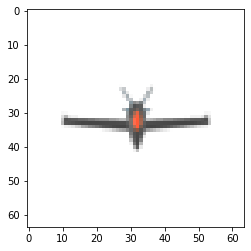

In [ ]:
import matplotlib.pyplot as plt

im = mpimg.imread(IMAGE_PATH)
plt.imshow(im)

# Import pretrained Model and Generate obj

In [ ]:
model = models.Model('SoftRas/data/obj/sphere/sphere_642.obj', args=args)
model = model.cuda()

state_dicts = torch.load(MODEL_DIRECTORY)

model.load_state_dict(state_dicts['model'], strict=True)
model.eval()

Model(
  (encoder): Encoder(
    (conv1): Conv2d(4, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=16384, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=512, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=2048, bias=True)
    (fc_centroid): Linear(in_features=2048, out_features=3, bias=True)
    (fc_bias): Linear(in_featur

In [ ]:
image = rev_img(im).reshape(-1,4,64,64)
image = torch.autograd.Variable(image).cuda()
print(image.shape)

torch.Size([1, 4, 64, 64])


In [ ]:
vertices, faces = model.reconstruct(image)
srf.save_obj(OBJ_PATH, vertices[0], faces[0])

# Visualize OBJ

In [ ]:
import pyvista

reader = pyvista.get_reader('objs/test.obj')
mesh = reader.read()
mesh.plot(cpos='yz', show_scalar_bar=False)